In [1]:
import numpy as np, pandas as pd
import json, pickle
import matplotlib.pyplot as plt

#import py modules:
import PES_data_processor as pdata, PES_models as pmodel

## ansatz vs CHIPR on OH$^+$ data

In [89]:
list_data = np.load('data/hxoy_data.npy', allow_pickle=True) #reload
list_data = list_data[()]

In [30]:
mol = "OH+"
qidxes = pdata.query_one_var_indices(mol, "mol", list_data)

In [37]:
#display the table result:


'''
data = pd.read_pickle("result/performance_22102021.pkl")
display = data[['num_params', 'ansatz_acc', 'chipr_acc','ansatz_t', 'chipr_t', ]]
display
'''

fname = "result/performance_02112021.pkl"
with open(fname, 'rb') as handle:
    data = pickle.load(handle)
filter = ['num_params', 'ansatz_1_acc', 'chipr_acc','ansatz_1_t', 'chipr_t']
display = {k:data[k] for k in filter if k in data}
display = pd.DataFrame(display) #filter the data
display

,num_params,ansatz_1_acc,chipr_acc,ansatz_1_t,chipr_t
0,16,0.023550,0.002265,0.0,0.001
1,32,0.009971,0.000618,0.0,0.000


==== Optimization stats ====
optimization restarts =  1
optimization power =  1
delta threshold =  1e-05
evaluation loops =  1
evaluation runs =  1
elapsed time =  25.049355030059814 s


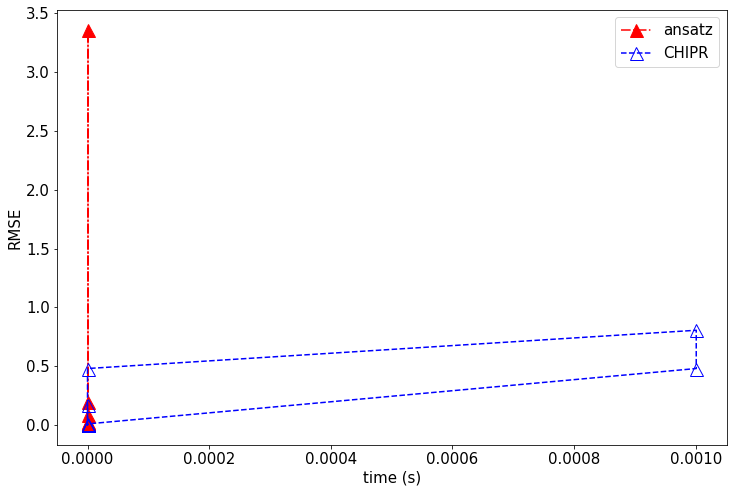

In [32]:
## plot of the table (finding which model is the best)
plt.rcParams.update({'font.size': 15})
plt.subplots(figsize=(12, 8))
markersize = 13
plt.plot(data["ansatz_1_t"], data["ansatz_1_acc"], '-.r^', markersize=markersize)
plt.plot(data["chipr_t"], data["chipr_acc"], '--b^', markersize=markersize, fillstyle="none")
#ticks = np.linspace(1, 9, 5) #5 ticks between 1-9 Angstrom
#plt.xticks(np.log10(ticks), ticks)
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.legend(["ansatz", "CHIPR"])
print("==== Optimization stats ====")
#print("data: ", list_data[qidxes[0]]["mol"], list_data[qidxes[0]]["state"], list_data[qidxes[0]]["author"], len(R),"data points")
print("optimization restarts = ",data["opt_restart"])
print("optimization power = ", data["opt_power"])
print("delta threshold = ", data["opt_delta"])
print("evaluation loops = ",data["eval_loop"])
print("evaluation runs = ",data["eval_run"])
print("elapsed time = ", data["simulation_time"], "s")

## Error plots

### <li>  Joint fit OH$^+$, ansatz vs CHIPR

In [115]:
#Query the data:
mol = "OH+"
qidxes = pdata.query_one_var_indices(mol, "mol", list_data)

#join the R and V:
R_list = []; V_list = []
for i in qidxes:
    R = list_data[i]["R"]
    V = list_data[i]["V"]
    R_list.append(R); V_list.append(V)

R_list = np.array(R_list); V_list = np.array(V_list)
R = np.concatenate(R_list)
V = np.concatenate(V_list)

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


In [128]:
#data = pd.read_pickle("result/res_joint_OH+_271021_153617.pkl")
data = pd.read_pickle("result/res_joint_OH+_291021_160942.pkl")
C_ans = np.array(data["ansatz_C"][0]); C_chipr = np.array(data["chipr_C"][0]); C_dn = np.array(data["dn_C"][0]); C_ds = np.array(data["ds_C"][0]) #adds [0] indexer due to pandas' length trickery
Cs = [C_ans, C_chipr, C_dn, C_ds]

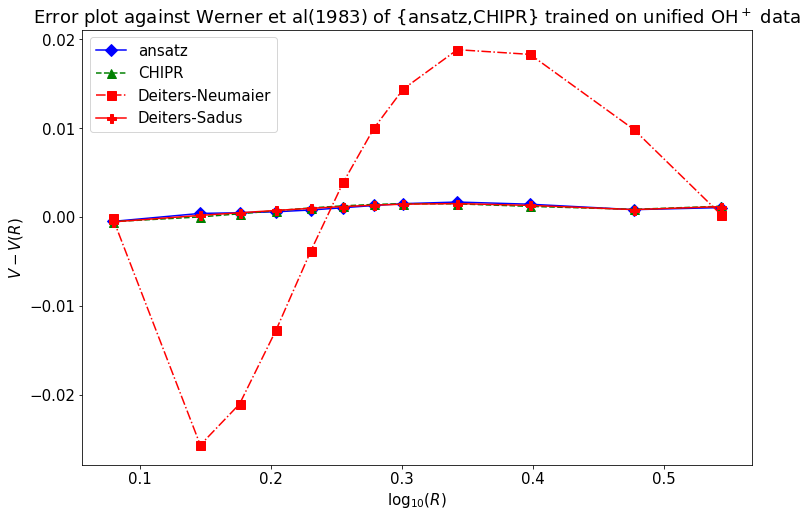

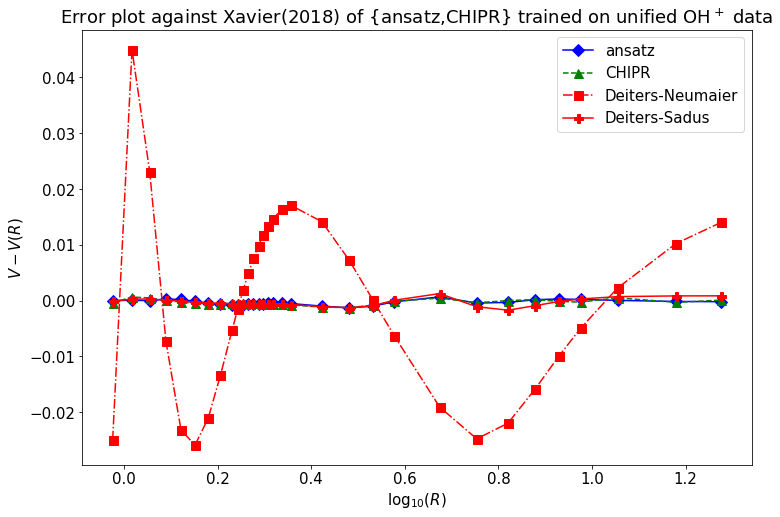

In [129]:
#plot the error on all OH+ data, error of ansatz vs CHIPR:
Fs = [pmodel.f_diatomic_vdw, pmodel.f_diatomic_chipr_ohplus, pmodel.f_diatomic_dn, pmodel.f_diatomic_ds]
Z = 8 
M = int((len(C_ans)-1)/3)
m = int((2*M - 2)/3)
shapes = ["-bD","--g^", "-.rs", "-rP"]; markersize=9
for i in range(len(V_list)):
    plt.subplots(figsize=(12, 8))
    args = [(R_list[i],Z,M), (R_list[i],Z,M,m), (R_list[i],), (R_list[i],)]
    for j in range(len(Fs)):
        f = Fs[j]
        C = Cs[j]
        V_pred = f(C, *args[j])
        err = V_pred - V_list[i]
        plt.plot(np.log10(R_list[i]), err, shapes[j], markersize=markersize)
    data = list_data[qidxes[i]]
    legends = ["ansatz", "CHIPR", "Deiters-Neumaier", "Deiters-Sadus"]
    plt.xlabel("log$_{10}(R)$")
    plt.ylabel("$V-V(R)$")
    plt.legend(legends)
    plt.title("Error plot against "+str(list_data[qidxes[i]]["author"])+" of {ansatz,CHIPR} trained on unified OH$^+$ data" )

### <li> Separate fit

In [ ]:
data = pd.read_pickle("result/res_each_state_271021_145320.pkl")
# OH+:
mol = "OH+"
Z = 8 #for OH+
M = int((data["num_params"][0]-1)/3)
m = int((2*M - 2)/3)
#get the C:
length = data.shape[0]
shapes = ["-bD","--g^"]
for i in range(length):
    if data["mol"][i] == mol:
        #plot per mol per state per author:
        qidx = pdata.query_many_vars_indices([mol, data["state"][i], data["author"][i]], ["mol", "state", "author"], list_data)
        R = list_data[qidx[0]]["R"]; V = list_data[qidx[0]]["V"]
        
        #ansatz:
        C = data["ansatz_C"][i]
        V_pred = pmodel.f_diatomic_vdw(C, R, Z, M)
        err_a = V_pred - V

        #chipr:
        C = data["chipr_C"][i]
        V_pred = pmodel.f_diatomic_chipr_ohplus(C, R, Z, M, m)
        err_c = V_pred - V
        
        plt.subplots(figsize=(12, 8))
        plt.plot(np.log10(R), err_a, shapes[0])
        plt.plot(np.log10(R), err_c, shapes[1])
        ticks = np.linspace(1, 9, 5) #5 ticks between 1-9 Angstrom
        plt.xticks(np.log10(ticks), ticks)
        legends = ["ansatz", "CHIPR"]
        plt.xlabel("R")
        plt.ylabel("$V-V(R)$")
        plt.legend(legends)
        plt.title("Error plot, separate fit, "+str(data["mol"][i])+", "+str(data["state"][i])+", "+str(data["author"][i]) )

In [ ]:
# All molecules:
data = pd.read_pickle("result/res_each_state_281021_130049.pkl")
print(data)

C:\Users\beryl\Documents\Coding\Python\pes\PES_models.py:40: RuntimeWarning: divide by zero encountered in true_divide
  inv_exp = 1/exp
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


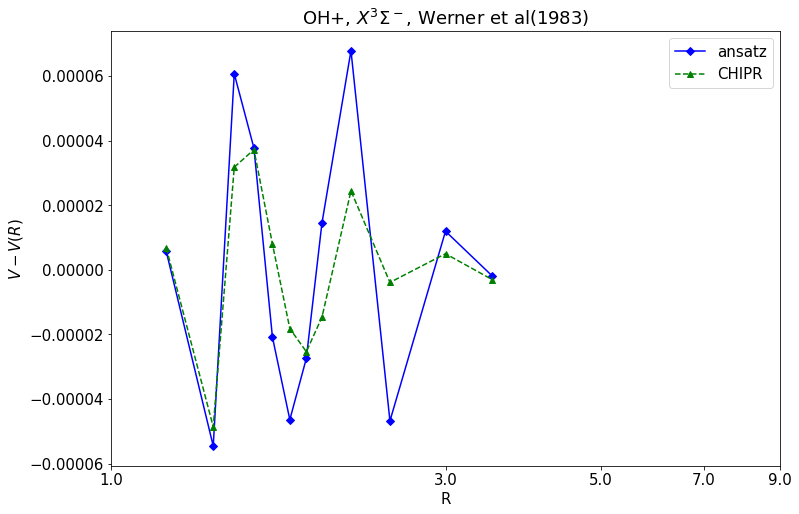

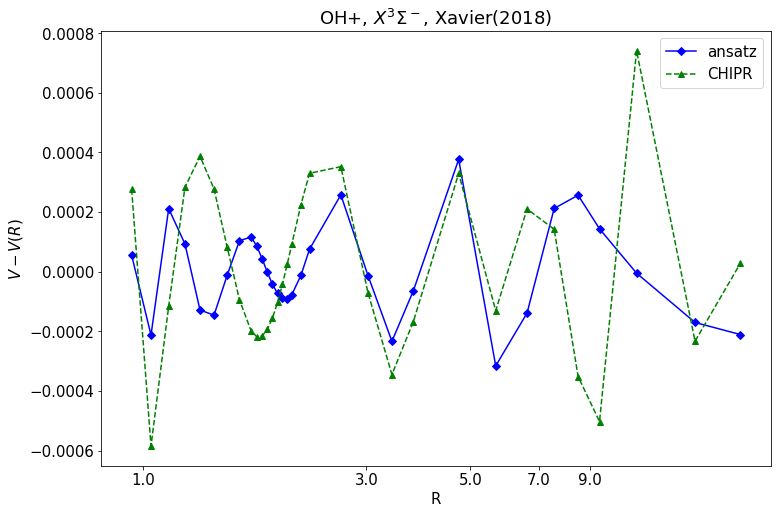

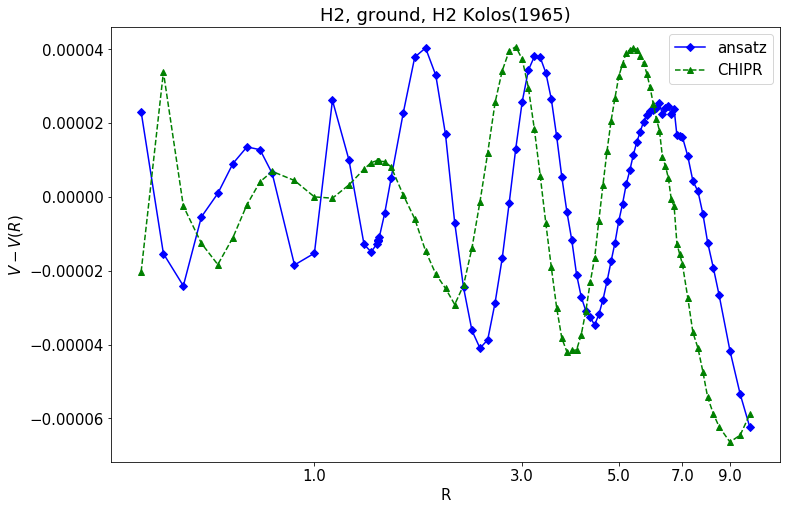

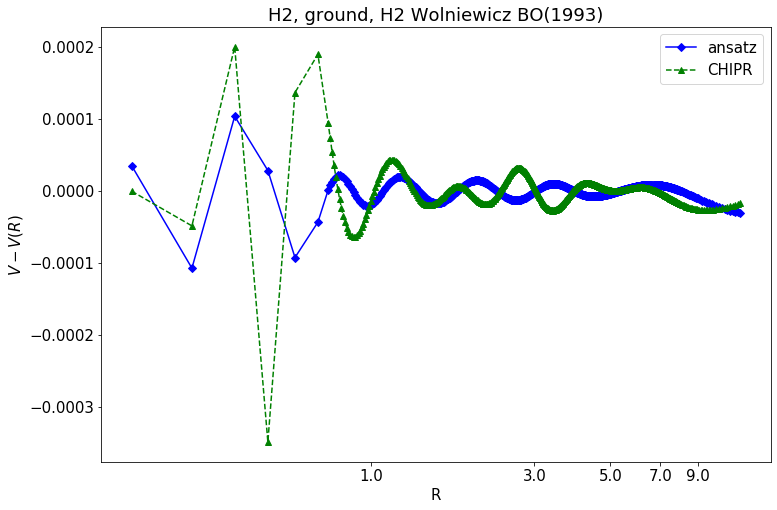

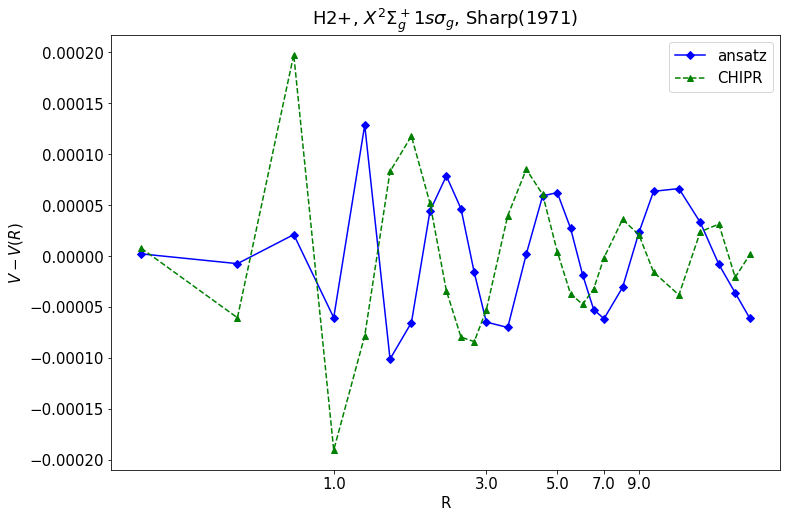

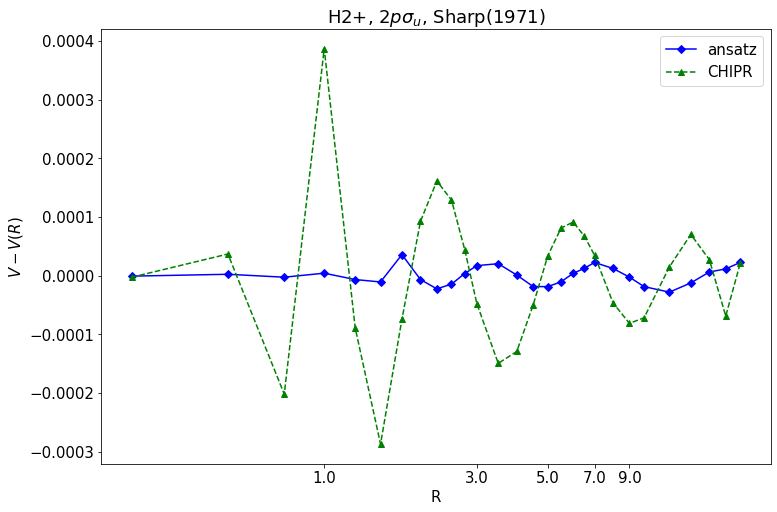

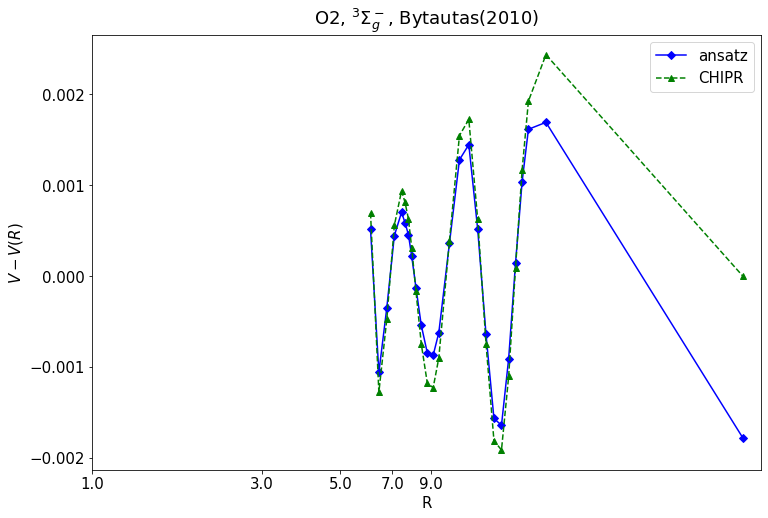

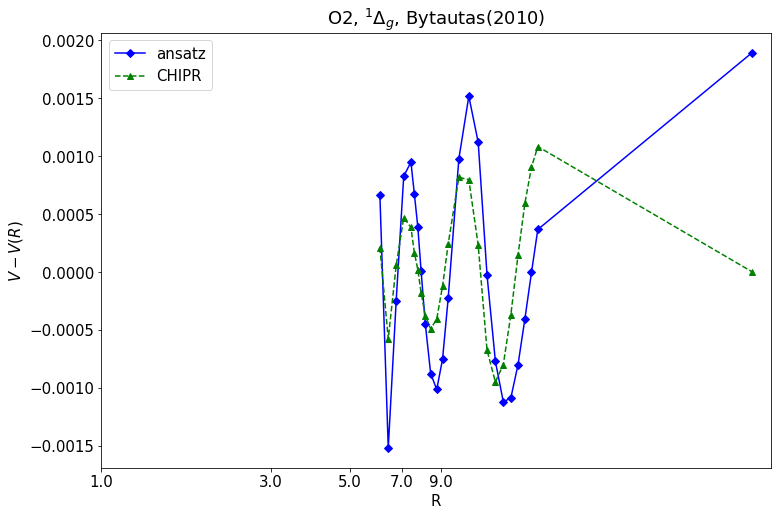

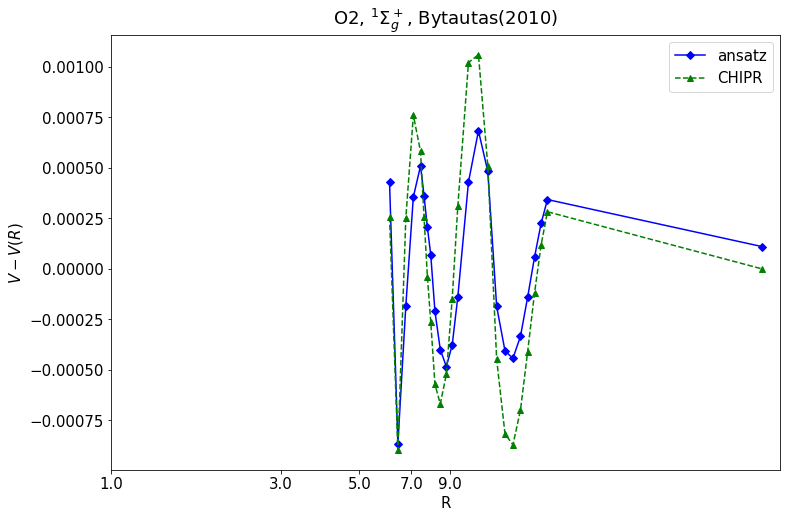

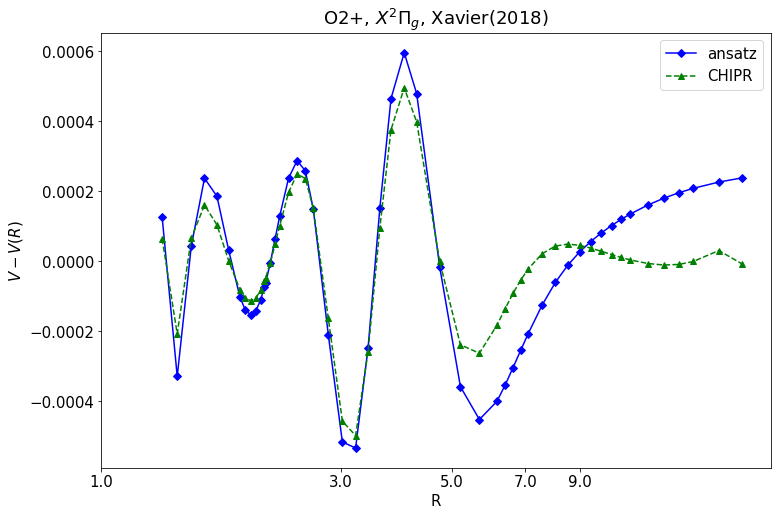

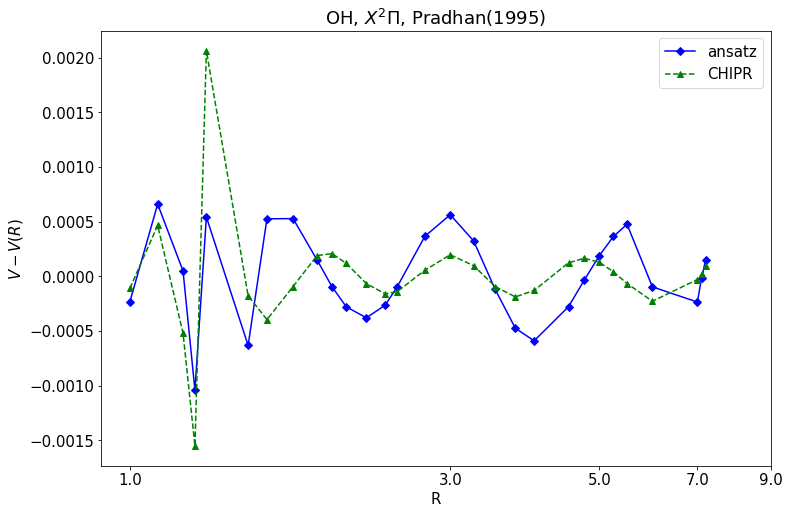

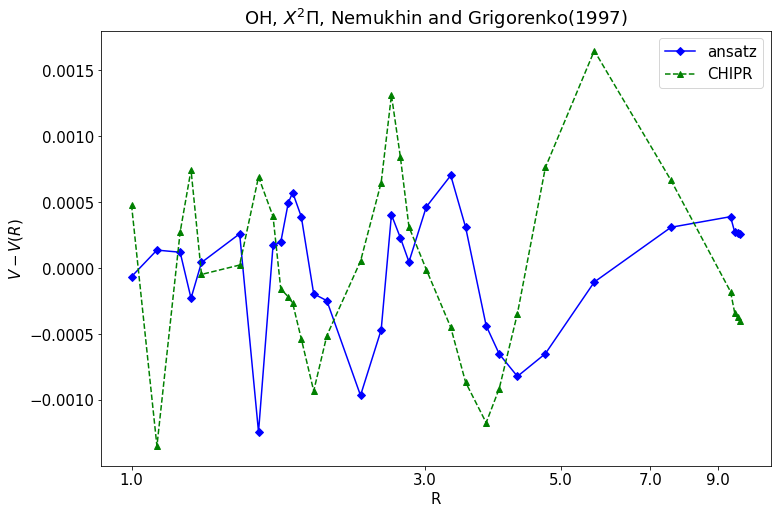

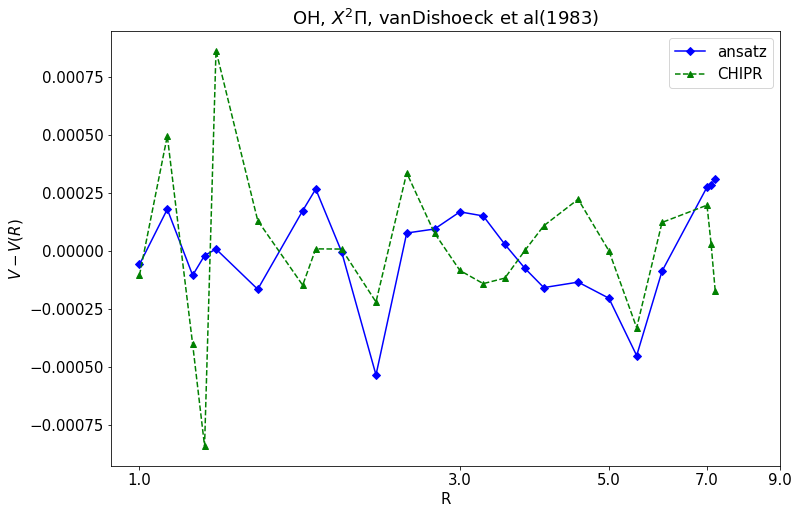

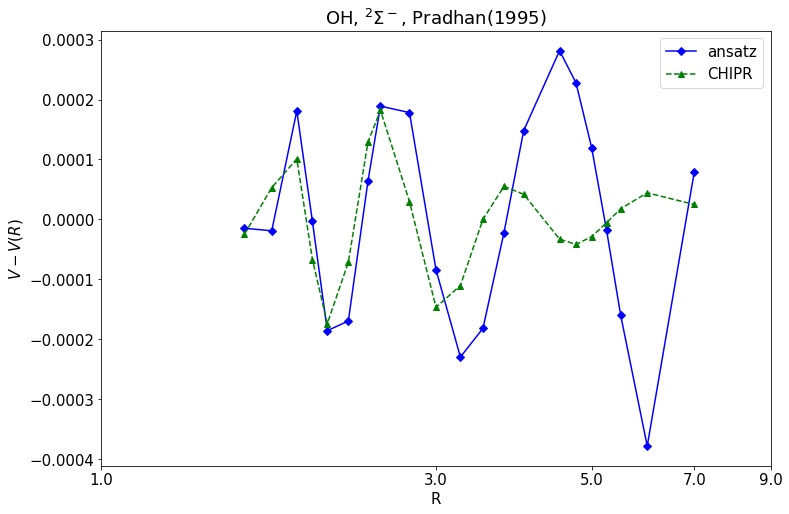

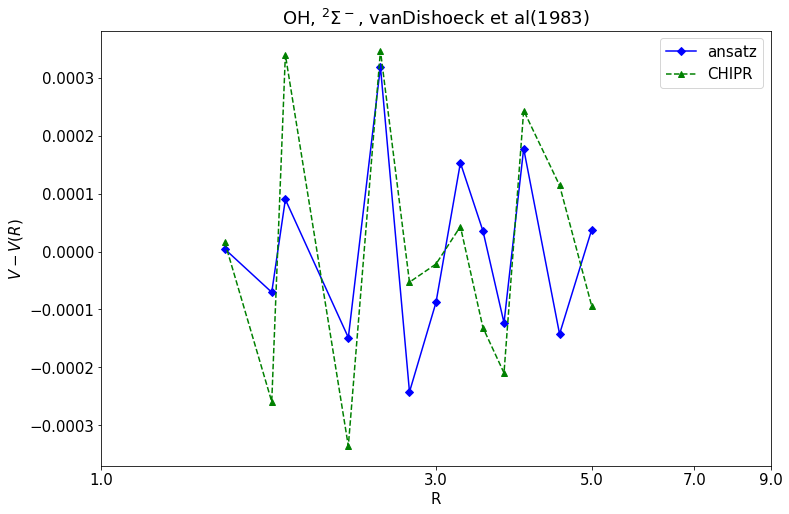

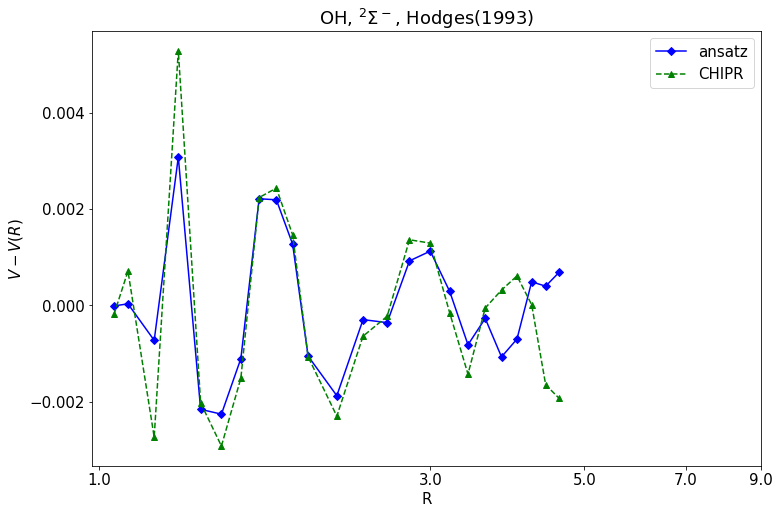

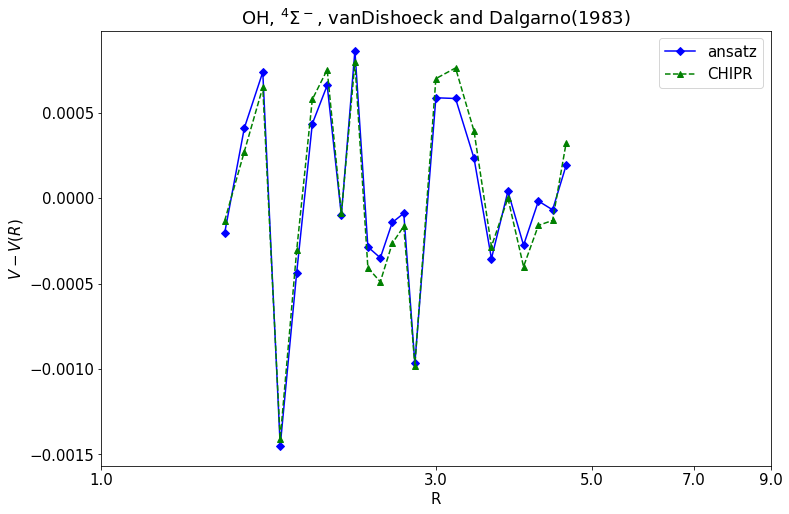

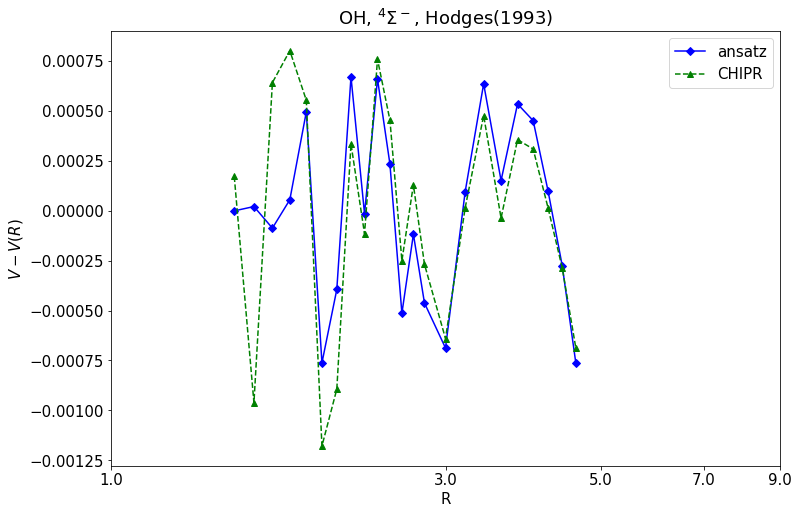

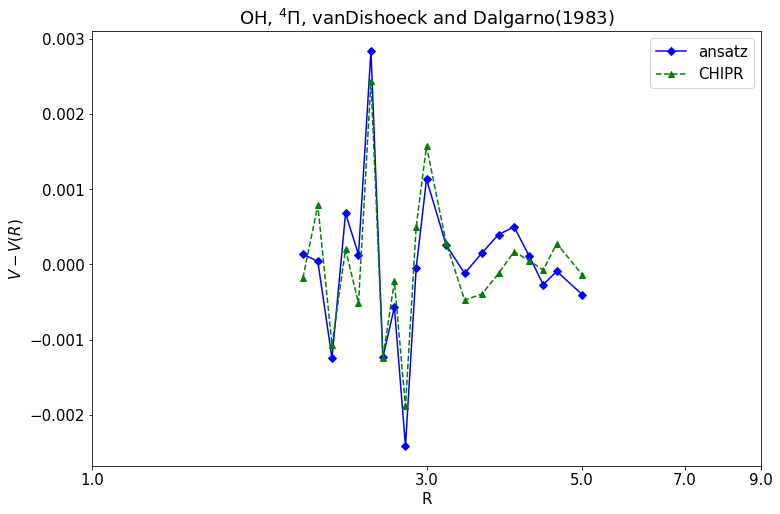

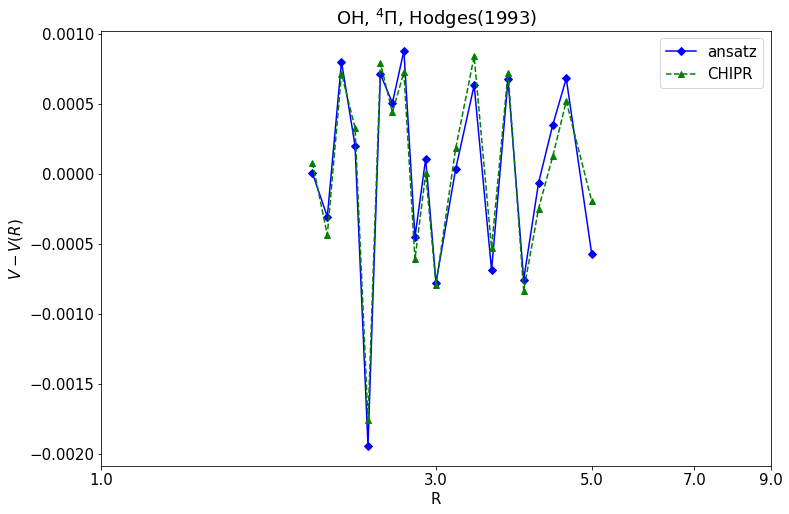

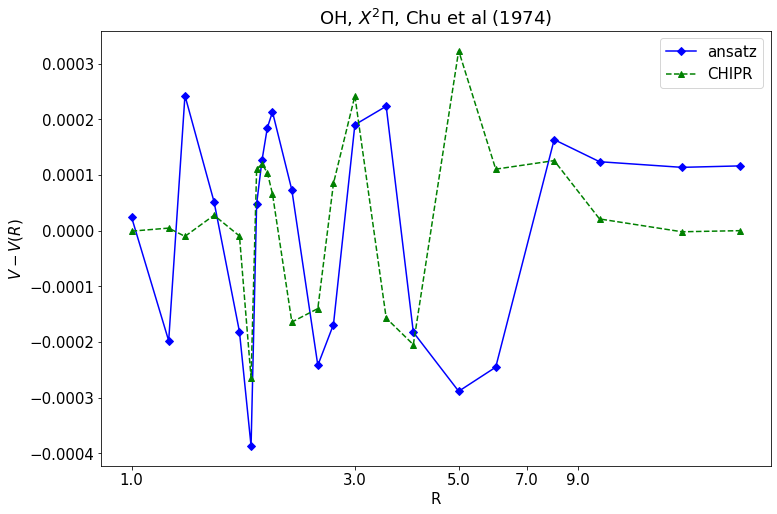

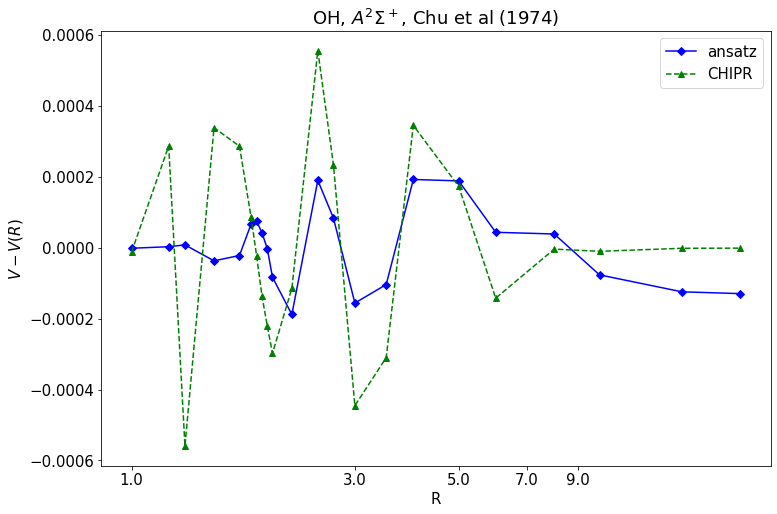

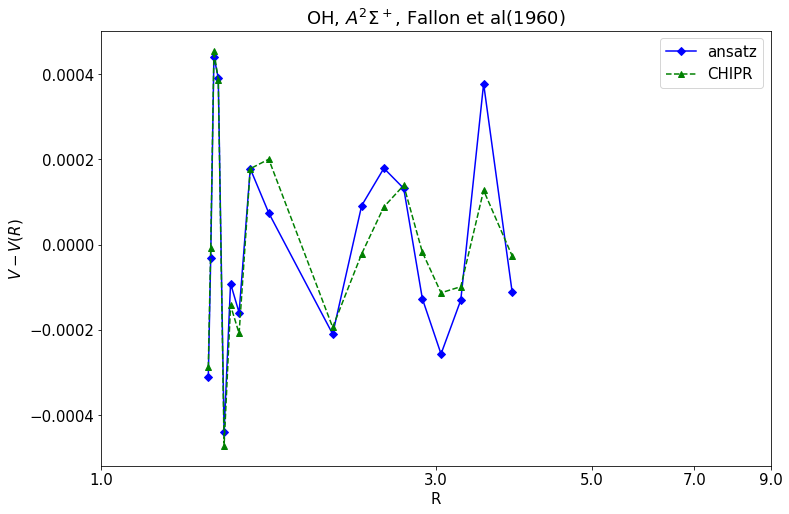

In [83]:
mols = ["OH+", "H2", "H2+", "O2", "O2+", "OH"]
#Zs = {"OH+":8, "H2":1, "H2+":1, "O2":64, "O2+":64, "OH":8}
M = int((data["num_params"][0]-1)/3)
m = int((2*M - 2)/3)
#get the C:
length = data.shape[0]
shapes = ["-bD","--g^"]
for mol in mols:
    for i in range(length):
        if data["mol"][i] == mol:
            #plot per mol per state per author:
            qidx = pdata.query_many_vars_indices([mol, data["state"][i], data["author"][i]], ["mol", "state", "author"], list_data)
            R = list_data[qidx[0]]["R"]; V = list_data[qidx[0]]["V"]; Z = data["Z"][i]

            #ansatz:
            C = data["ansatz_C"][i]
            V_pred = pmodel.f_diatomic_vdw(C, R, Z, M)
            err_a = V_pred - V

            #chipr:
            C = data["chipr_C"][i]
            V_pred = pmodel.f_diatomic_chipr_ohplus(C, R, Z, M, m)
            err_c = V_pred - V

            plt.subplots(figsize=(12, 8))
            plt.plot(np.log10(R), err_a, shapes[0])
            plt.plot(np.log10(R), err_c, shapes[1])
            ticks = np.linspace(1, 9, 5) #5 ticks between 1-9 Angstrom
            plt.xticks(np.log10(ticks), ticks)
            legends = ["ansatz", "CHIPR"]
            plt.xlabel("R")
            plt.ylabel("$V-V(R)$")
            plt.legend(legends)
            plt.title(str(data["mol"][i])+", "+str(data["state"][i])+", "+str(data["author"][i]) )